#  Brain-body-behavior descriptors ME

## Task and reference performance
**Walker-v0** -> walk forward on an even terrain; usual performance around 8-10

## Descriptors recap
- Brain: nns descriptors
- Body: (1) n active voxels / n voxels, (2) elongation
- Behavior: (1) y-velocity (median of fft), (2) % of contact with ground

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jupyter_server.auth import passwd

from qdax.utils.plotting import plot_2d_map_elites_repertoire
from scipy.stats import ranksums
%matplotlib inline

In [2]:
dfs = []
for sampler in ["all", "s1", "s2", "s3", "ga"]:
    for seed in range(10):
        try:
            if sampler != "ga":
                tmp_df = pd.read_csv(f"../results/me_nn/PCA-evo-body-10x10-walker-{sampler}_{seed}.csv")
            else:
                tmp_df = pd.read_csv(f"../results/ga/evo-body-nn-10x10-walker_{seed}.csv")
            tmp_df["sampler"] = sampler
            tmp_df["seed"] = seed
            dfs.append(tmp_df)
        except FileNotFoundError:
            print(sampler, seed)
df = pd.concat(dfs)
df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,sampler,seed
0,1,0.562116,5.652280,3.231952,2.908106,2.929688,6.640625,2.246094,11.388924,2024-12-02 13:35:18.571949,0.0,all,0
1,2,0.562116,7.412463,4.919590,3.104527,3.125000,8.593750,2.734375,5.778678,2024-12-02 13:35:24.350963,0.0,all,0
2,3,0.562116,8.975650,8.650234,3.866097,3.222656,10.058594,2.929688,5.733377,2024-12-02 13:35:30.084858,0.0,all,0
3,4,0.609543,10.033884,11.207098,4.322552,3.320312,11.523438,2.929688,5.646115,2024-12-02 13:35:35.731445,0.0,all,0
4,5,0.609543,10.713839,14.359545,4.868412,3.320312,12.304688,3.222656,5.769140,2024-12-02 13:35:41.501045,0.0,all,0


In [3]:
final_df = df[df["iteration"] == max(df["iteration"])]
final_df.head()

,iteration,max_fitness,qd_score1,qd_score2,qd_score3,coverage1,coverage2,coverage3,time,current_time,invalid_individuals,sampler,seed
3999,4000,10.449953,4718.8115,2498.8071,2663.1133,100.00000,52.441406,56.347656,6.022056,2024-12-02 20:07:36.555792,0.0,all,0
3999,4000,10.394796,3451.5713,2499.5205,2598.1670,100.00000,54.296875,58.007812,5.968364,2024-12-03 02:47:34.360531,0.0,all,1
3999,4000,10.669969,5012.3174,2568.1147,2574.1070,100.00000,52.636720,53.125000,6.101005,2024-12-03 09:26:42.957216,0.0,all,2
3999,4000,10.520744,4690.1280,2741.4730,2436.9473,100.00000,55.273438,54.101562,6.258300,2024-12-03 16:10:46.402554,0.0,all,3
3999,4000,9.031404,3036.9998,2067.5160,2034.9697,99.70703,51.269530,59.863280,6.156491,2024-12-03 22:58:40.345502,0.0,all,4


## Fitness results

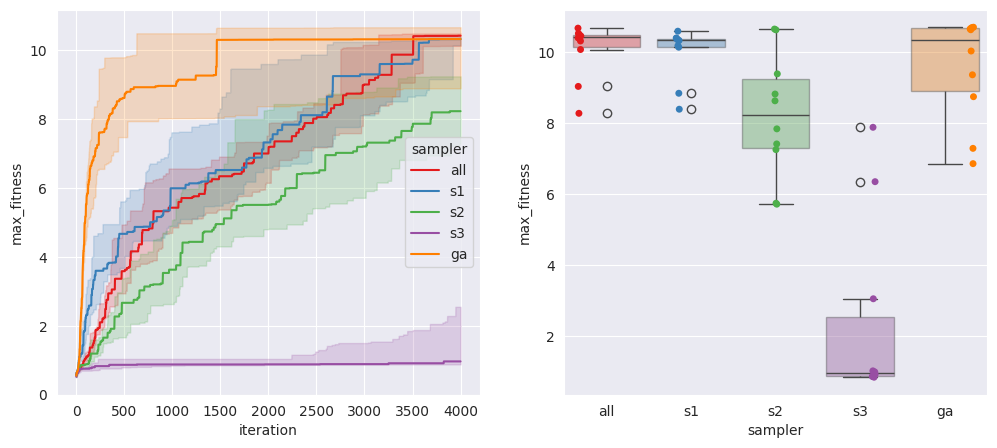

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(df,
             x="iteration",
             y="max_fitness",
             estimator="median",
             errorbar=("pi", 50),
             hue="sampler",
             palette="Set1",
             ax=axs[0]
             )
sns.boxplot(
    final_df,
    x="sampler",
    y="max_fitness",
    hue="sampler",
    palette="Set1",
    boxprops={'alpha': 0.4},
    ax=axs[1]
)
sns.stripplot(final_df,
              x="sampler",
              y="max_fitness",
              hue="sampler",
              palette="Set1",
              dodge=True,
              ax=axs[1])
plt.show()

In [5]:
pairs = []
for s1 in final_df.sampler.unique():
    for s2 in final_df.sampler.unique():
        if s1 != s2 and (s2, s1) not in pairs:
            pairs.append((s1, s2))
            fits1 = final_df[final_df["sampler"] == s1]["max_fitness"].to_list()
            fits2 = final_df[final_df["sampler"] == s2]["max_fitness"].to_list()
            _, p_value = ranksums(fits1, fits2)
            print(f"{s1} vs {s2} -> {p_value}")

all vs s1 -> 0.3257513544787166
all vs s2 -> 0.034293721036492766
all vs s3 -> 0.00015705228423075119
all vs ga -> 0.8205958397554409
s1 vs s2 -> 0.0493661947519327
s1 vs s3 -> 0.00015705228423075119
s1 vs ga -> 0.7054569861112734
s2 vs s3 -> 0.0011520450981421845
s2 vs ga -> 0.05878172135535886
s3 vs ga -> 0.00028511808363161265


## Coverage results
- sampling from repertoire x fosters diversity/coverage in x
- sampling from all repertoires is the second-best option for each, i.e., the best trade-off

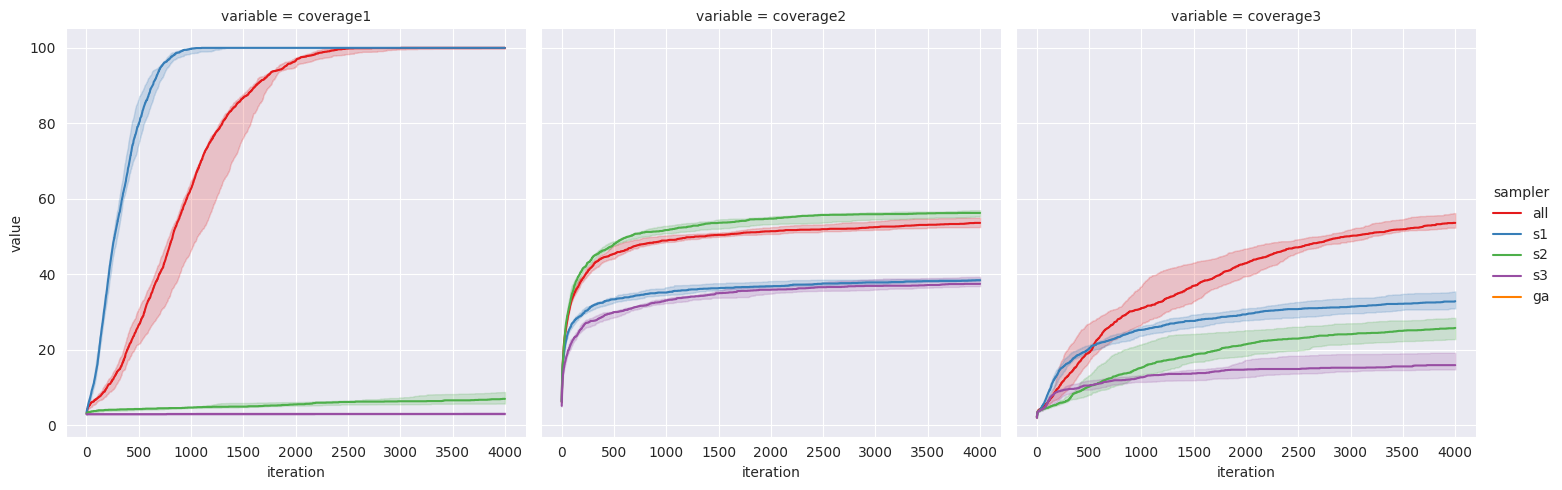

In [6]:
df_wide = pd.melt(df, id_vars=["iteration", "max_fitness", "time", "current_time", "sampler", "seed"],
                  value_vars=["coverage1", "coverage2", "coverage3"])
sns.relplot(df_wide,
            x="iteration",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="line",
            estimator="median",
            errorbar=("pi", 50),
            )
plt.show()

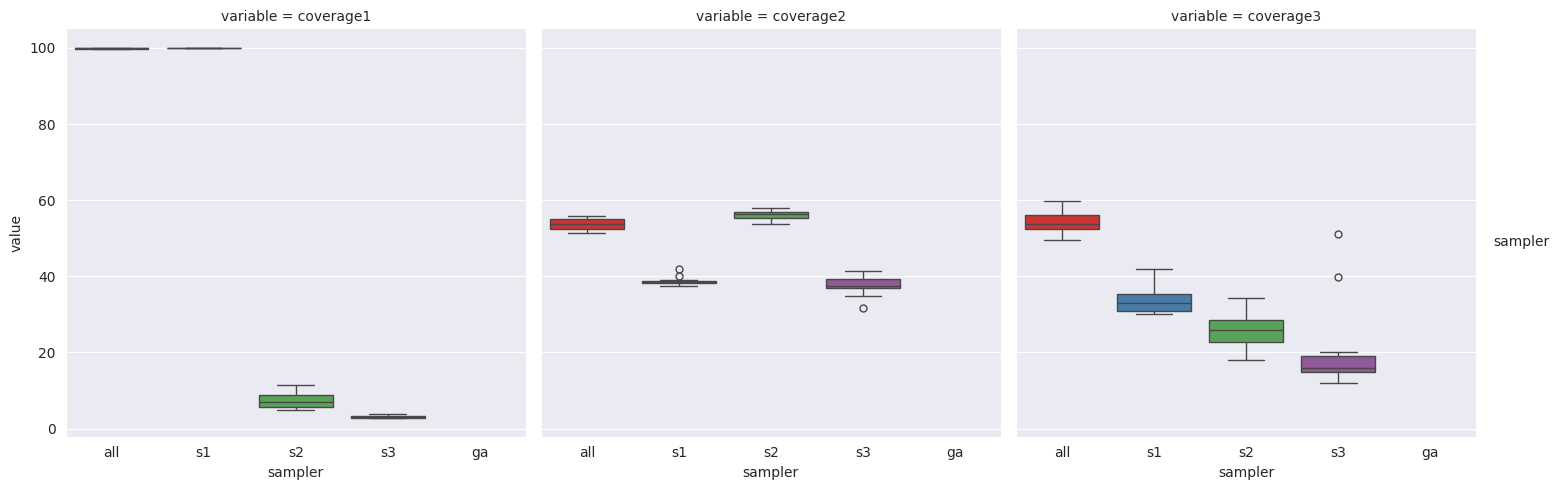

In [7]:
final_df_wide = df_wide[df_wide["iteration"] == max(df_wide["iteration"])]
sns.catplot(final_df_wide,
            x="sampler",
            y="value",
            col="variable",
            hue="sampler",
            palette="Set1",
            kind="box",
            )
plt.show()

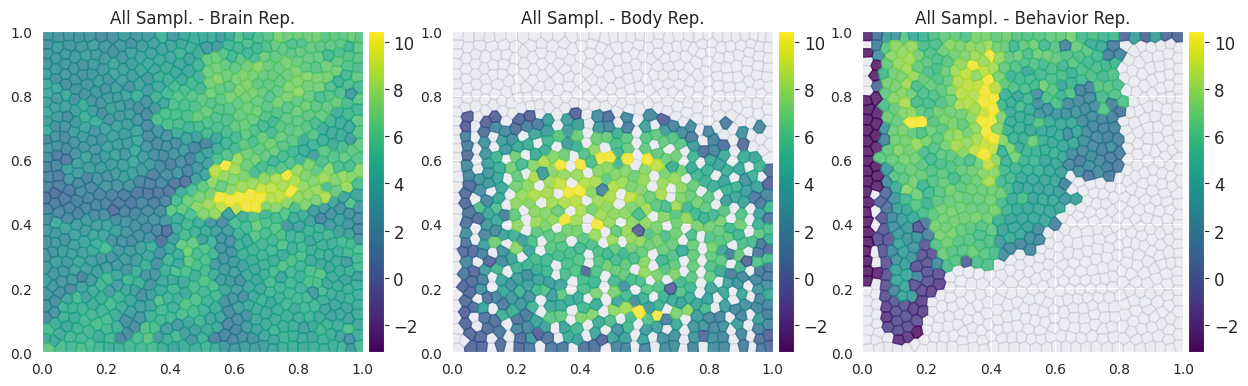

In [8]:
samplers = ["all"]
rep_seed = 0
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
reps = {
    0: "Brain",
    1: "Body",
    2: "Behavior"
}
sams = {
    "all": "All",
}
min_fit, max_fit = jnp.inf, -jnp.inf
for i, sampler in enumerate(samplers):
    base_path = f"../results/me_nn/PCA-evo-body-10x10-walker-{sampler}_{rep_seed}"
    for r, ax in enumerate(axs):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        curr_min_fit, curr_max_fit = min(fitnesses[fitnesses > -jnp.inf]), max(fitnesses)
        if curr_min_fit < min_fit: min_fit = curr_min_fit
        if curr_max_fit > max_fit: max_fit = curr_max_fit

for i, sampler in enumerate(samplers):
    base_path = f"../results/me_nn/PCA-evo-body-10x10-walker-{sampler}_{rep_seed}"
    for r, ax in enumerate(axs):
        centroids = jnp.load(f"{base_path}/r{r + 1}_centroids.npy")
        fitnesses = jnp.load(f"{base_path}/r{r + 1}_fitnesses.npy")
        plot_2d_map_elites_repertoire(centroids, fitnesses, 0, 1, ax=ax, vmin=min_fit, vmax=max_fit)
        ax.set_title(f"{sams[sampler]} Sampl. - {reps[r]} Rep.")
        ax.set_xlabel("")
        ax.set_ylabel("")
plt.show()

## Coverage transfer

In [9]:
samplers = ["all", "s1", "s2", "s3"]
seeds = range(4)
repertoires = range(1, 4)
coverage_dfs = []
for sampler in samplers:
    for repertoire in repertoires:
        for seed in seeds:
            tmp_df = pd.read_csv(f"../results/coverage/PCA_nn_PCA-evo-body-10x10-walker-{sampler}_{seed}_g{repertoire}.csv")
            tmp_df["sampler"] = sampler
            tmp_df["seed"] = seed
            tmp_df["origin_repertoire"] = repertoire
            coverage_dfs.append(tmp_df)
coverage_df = pd.concat(coverage_dfs)
coverage_df = pd.melt(coverage_df, id_vars=["max_fitness", "sampler", "seed", "origin_repertoire"],
                      value_vars=["coverage1", "coverage2", "coverage3"])
coverage_df = coverage_df.rename(columns={"variable": "destination_repertoire", "value": "coverage"})
coverage_df["destination_repertoire"] = coverage_df["destination_repertoire"].apply(
    lambda x: int(x.replace("coverage", "")))
coverage_df.head()

,max_fitness,sampler,seed,origin_repertoire,destination_repertoire,coverage
0,10.449953,all,0,1,1,100.000000
1,10.394796,all,1,1,1,100.000000
2,10.669969,all,2,1,1,100.000000
3,10.520744,all,3,1,1,100.000000
4,10.449953,all,0,2,1,15.332031


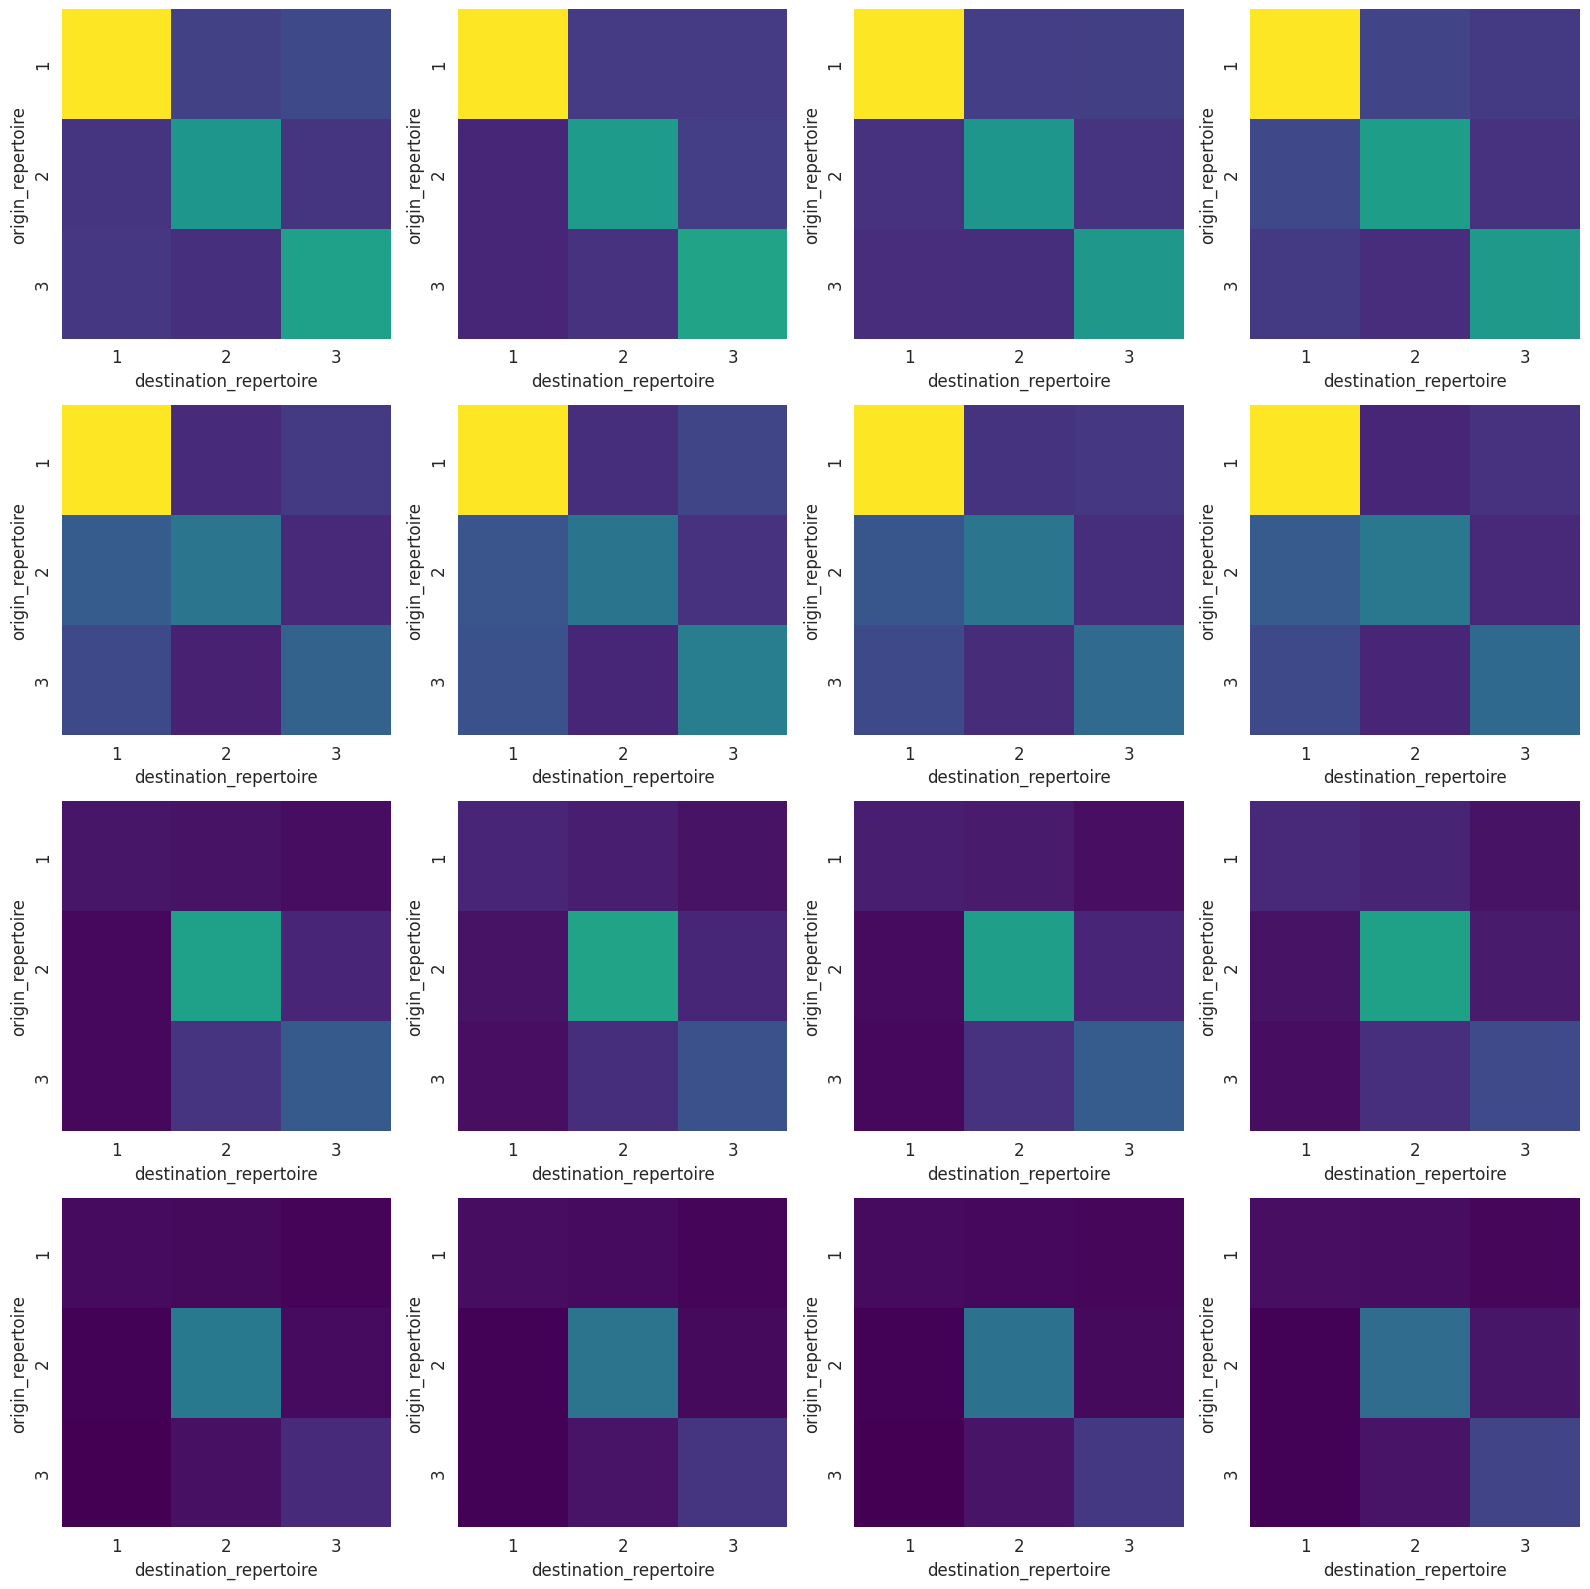

In [10]:
multiplier = 4
max_coverage = max(coverage_df["coverage"])
fig, axes = plt.subplots(len(samplers), len(seeds), figsize=(multiplier * len(seeds), multiplier * len(samplers)))
for seed_id, seed in enumerate(seeds):
    for sampler_id, sampler in enumerate(samplers):
        tmp_coverage_df = coverage_df[(coverage_df["sampler"] == sampler) & (coverage_df["seed"] == seed)]
        tmp_hm_data = tmp_coverage_df.pivot(index="origin_repertoire", columns="destination_repertoire",
                                            values="coverage")
        sns.heatmap(tmp_hm_data, ax=axes[sampler_id][seed_id], cmap="viridis", vmin=0, vmax=max_coverage, cbar=False)
plt.tight_layout()
plt.show()

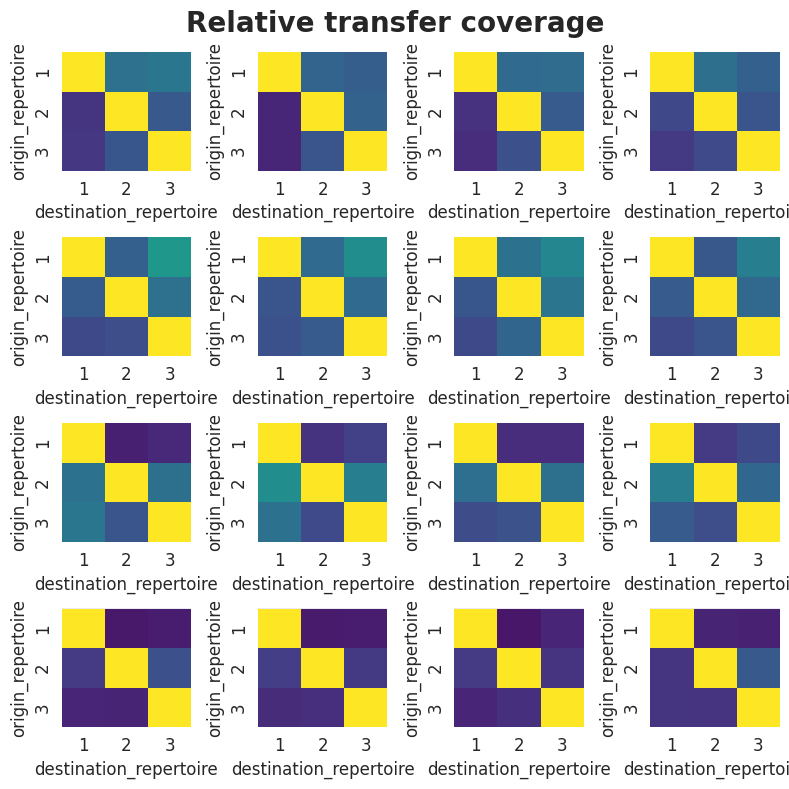

In [11]:
multiplier = 2
# max_coverage = max(coverage_df["coverage"])
fig, axes = plt.subplots(len(samplers), len(seeds), figsize=(multiplier * len(seeds), multiplier * len(samplers)))
for seed_id, seed in enumerate(seeds):
    for sampler_id, sampler in enumerate(samplers):
        tmp_coverage_df = coverage_df[(coverage_df["sampler"] == sampler) & (coverage_df["seed"] == seed)]
        c_1 = \
            tmp_coverage_df[
                (tmp_coverage_df["origin_repertoire"] == 1) & (tmp_coverage_df["destination_repertoire"] == 1)][
                "coverage"].iloc[0]
        c_2 = \
            tmp_coverage_df[
                (tmp_coverage_df["origin_repertoire"] == 2) & (tmp_coverage_df["destination_repertoire"] == 2)][
                "coverage"].iloc[0]
        c_3 = \
            tmp_coverage_df[
                (tmp_coverage_df["origin_repertoire"] == 3) & (tmp_coverage_df["destination_repertoire"] == 3)][
                "coverage"].iloc[0]
        clear_coverage_df = tmp_coverage_df.copy()
        clear_coverage_df["relative_coverage"] = clear_coverage_df.apply(
            lambda row: (row["coverage"] / c_1) if row["destination_repertoire"] == 1 else
            ((row["coverage"] / c_2) if row["destination_repertoire"] == 2 else (row["coverage"] / c_3)),
            axis=1)
        tmp_hm_data = clear_coverage_df.pivot(index="origin_repertoire", columns="destination_repertoire",
                                              values="relative_coverage")
        sns.heatmap(tmp_hm_data, ax=axes[sampler_id][seed_id], cmap="viridis", vmin=0, vmax=1, cbar=False)

fig.suptitle("Relative transfer coverage", fontsize=20, fontweight="bold")
plt.tight_layout()
plt.show()